In [1]:
!pip install -U pip
!pip install lmfit
!pip install pyarrow

DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author

In [2]:
fit_ch=1

In [3]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.signal
import pandas as pd
import time
import traceback
from glob import glob
#from sys import argv
from os.path import splitext, exists
from lmfit.models import ConstantModel, GaussianModel
from lmfit import Model
from datetime import datetime as dt

import argparse

shingo_model = True

In [4]:
# Resolution of the CAEN digitiser
digi_res = 4 # ns
qhist_bins = 500 # Number of bins to use when fitting and histing qint
peak_prominence_fac = 200 # Prominance will be max value of hist/this
digi_channels = 4 # number of channels in the digitiser

# What to scale the gain calc by (to get diff units)
# Digitiser resolution in ns, switch to s
# Switch mV to V
# Divide by e to get to gain
gain_scale = digi_res*1e-9*1e-3/1.602e-19

# Resistance of cable
gain_scale /= 50 # Ohm

In [5]:
#https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model
def gaussian(x, amp, centre, sigma):
    #return (amp/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power(x-centre,2)/(2*np.power(sigma,2)))
    return amp*np.exp(-np.power(x-centre,2)/(2*np.power(sigma,2)))

def exp_bg(x, alpha, w):
    f = w*alpha*np.exp(-alpha*x)
    f[np.where(x<0.)] = 0.
    return f

#def fullPEfunction(x, amp0, centre0, sigma0, amp1, centre1, sigma1, famp2, famp3, amp_dskip, fcentre_dskip, sigma_dskip):
#    f = gaussian(x, amp0, centre0, sigma0) + gaussian(x, amp1, centre1, sigma1) + gaussian(x, amp1*famp2, (2*centre1-centre0), sigma1) + gaussian(x, amp1*famp2*famp3, (3*centre1-centre0), sigma1) + gaussian(x, amp_dskip, (1.-fcentre_dskip)*centre0+fcentre_dskip*centre1, sigma_dskip)
#    return f

def fullPEfunction(x, amp0, centre0, sigma0, amp1, centre1, sigma1, famp2, famp3, alpha, w):
    #f = gaussian(x, amp0, centre0, sigma0) + gaussian(x, amp1, centre1, sigma1) + gaussian(x, amp1*famp2, (2*centre1-centre0), sigma1) + gaussian(x, amp1*famp2*famp3, (3*centre1-centre0), sigma1) + exp_bg((x-centre0), alpha, w)
    f = gaussian(x, amp0, centre0, sigma0) + gaussian(x, amp1, centre1, sigma1) + gaussian(x, amp1*famp2, (2*centre1-centre0), 1.414*sigma1) + gaussian(x, amp1*famp2*famp3, (3*centre1-centre0), 2.436*sigma1) + exp_bg((x-centre0), alpha, w)
    return f

In [6]:
def error(x, y, method='+'):
    z = 0.
    zerr = 0.

    if method == '+':
        z = x[0] + y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '-':
        z = x[0] - y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '*':
        z = x[0] * y[0]
        zerr = np.sqrt( (x[0]*y[1])**2 + (y[0]*x[1])**2 )
    if method == '/':
        z = x[0] / y[0]
        zerr = np.sqrt( (x[1]/y[0])**2 + ((x[0]*y[1])/(y[0]**2))**2 )

    return (z, zerr)

In [7]:

def get_channel_labels(args):
    """
    Parse argv to get the labels of each channel, usually which PMT is connected
    """
    # Default to generic labelling if none are given 
    if args.channels:
        return args.channels
    else:
        print("No channel labels given, will use default labelling.")
        print("Use --channels [label1] [label2] ... to label channels.")
        return [f"Channel {i}" for i in range(digi_channels)]


In [8]:

def fit_wform(wform):
    """
    Fits the waveform, assuming linear background and gaussian peak.

    :param np.array wform: Numpy array of the waveform to fit.
    """
    mod_bg = ConstantModel(prefix="bg_")
    mod_peak = GaussianModel(prefix="g1_")

    model = mod_bg + mod_peak

    # Guess the center as the global minimum, scaled by digitiser res
    g1_center = digi_res*np.argmin(wform)

    # Very basic guess of amplitude as average
    bg_amplitude = sum(wform)/len(wform)

    model.set_param_hint("g1_center", value=g1_center)
    model.set_param_hint("g1_amplitude", value=-5, min=-1)
    model.set_param_hint("g1_sigma", value=5)
    model.set_param_hint("bg_amplitude", value=bg_amplitude)

    params = model.make_params()

    # try:
    #     params = model.make_params(g1_amplitude=-5, g1_center=g1_center, 
    #         g1_sigma=2, bg_amplitude=3600)
    # except:
    #     print("!!Issue setting wform fit model params!!")
    #     params = model.make_params()

    # Scale x to fit to real time values
    xs = [digi_res*x for x in range(len(wform))]
    result = model.fit(wform, params, calc_covar=True, iter_cb=True, varbose=True, x=xs)

    # print(result.fit_report())

    return result


In [9]:
def fit_qhist_luminous(qs):
    # Get rid of qs where calculation is perfectly 0 for some reason
    qs_filter = [q for q in qs if q != 0]
    
    # Bin the integrated charges 
    qs_hist, qs_binedges = np.histogram(qs_filter, bins=qhist_bins)

    # Get centre of bins instead of edges
    bin_width = qs_binedges[1]-qs_binedges[0]

    # Includes all edges, get rid of last edge
    qs_bincentres = qs_binedges[:-1] + (bin_width/2)

    # Get rid of tiny bins by removing bins with less than qs_cut_thresh in
    #qs_bincentres_cut = []
    #qs_hist_cut = []
    #qs_cut_thresh = max(qs_hist)/1e4
    #for bincent, q in zip(qs_bincentres, qs_hist):
    #    if q > qs_cut_thresh:
    #        qs_bincentres_cut.append(bincent)
    #        qs_hist_cut.append(q)
    #qs_hist = [x for x in qs_hist_cut]
    #qs_bincentres = [x for x in qs_bincentres_cut]
    ## updated by shingo Feb. 2024
    qs_cut_thresh = min(np.array(qs_hist)[np.array(qs_hist)>0.])*1.0 # 1event
    #qs_hist = np.array(qs_hist)
    trim_range = [np.where(qs_hist>qs_cut_thresh)[0][0], np.where(qs_hist>qs_cut_thresh)[0][-1]] 
    qs_bincentres = qs_bincentres[trim_range[0] : trim_range[1]]
    qs_hist = qs_hist[trim_range[0] : trim_range[1]]

    # Scale bin values to area normalise to 1
    qs_hist = qs_hist/(sum(qs_hist)*bin_width)
    
    np.save('qs_hist.npy',np.array(qs_hist))
    np.save('qs_bincentres.npy', np.array(qs_bincentres))


    # Find a peak
    peak_height = qs_hist.max()
    peak_i = qs_hist.argmax()
    centre   = np.array(qs_bincentres)[peak_i]

    print('peak_height', peak_height)
    print('peak_i', peak_i)
    print('centre', centre)

    qs_hist = np.array(qs_hist)
    qs_bincentres = np.array(qs_bincentres)
    
    model = GaussianModel()
    params = model.guess(qs_hist, x=qs_bincentres)
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')

    print('params', qfit.params)


    # Get each individual component of the model
    components = qfit.eval_components()

    qfit_fig, qfit_ax = plt.subplots()
    qfit_fig.set_size_inches(14,8)

    qfit_ax.bar(qs_bincentres, qs_hist, width=bin_width, label="Data", alpha=0.5)
    qfit_ax.plot(qs_bincentres, qfit.best_fit, label="Best Fit")

    qfit_ax.vlines(qfit.best_values['center'], 0, max(qs_hist), colors="grey", linestyles="--", alpha=0.5)
    qfit_ax.legend()
    qfit_ax.set_ylim(bottom=0.1/len(qs))
    qfit_ax.set_yscale("log")

    return qfit, qs_hist, qs_bincentres, peak_i, qfit_ax, qfit_fig    



In [10]:

def fit_qhist(qs, npe=2):
    """
    Fits Gaussians to the integrated charge histogram, fitting the pedestal, 1pe
    and 2pe peaks. Bins within the function.

    :param list of int qs: The integrated charges from each individual waveform.
    :param int npe: The number of pe peaks to fit (not including pedestal).
    :param int or float peak_spacing: The guess at where the **1pe** peak will
        be. Subsequent pe peak guesses will be spaced equally apart.
    :param int or float peak_width: The guess at the sigma of the **1pe** peak.
        Subsequent peaks will be doubled.
    """

    # Get rid of qs where calculation is perfectly 0 for some reason
    qs_filter = [q for q in qs if q != 0]
    
    # Bin the integrated charges 
    qs_hist, qs_binedges = np.histogram(qs_filter, bins=qhist_bins)

    # Get centre of bins instead of edges
    bin_width = qs_binedges[1]-qs_binedges[0]

    # Includes all edges, get rid of last edge
    qs_bincentres = qs_binedges[:-1] + (bin_width/2)

    # Get rid of tiny bins by removing bins with less than qs_cut_thresh in
    #qs_bincentres_cut = []
    #qs_hist_cut = []
    #qs_cut_thresh = max(qs_hist)/1e4
    #for bincent, q in zip(qs_bincentres, qs_hist):
    #    if q > qs_cut_thresh:
    #        qs_bincentres_cut.append(bincent)
    #        qs_hist_cut.append(q)
    #qs_hist = [x for x in qs_hist_cut]
    #qs_bincentres = [x for x in qs_bincentres_cut]
    ## updated by shingo Feb. 2024
    qs_cut_thresh = min(np.array(qs_hist)[np.array(qs_hist)>0.])*3.0 # 3event
    #qs_hist = np.array(qs_hist)
    trim_range = [np.where(qs_hist>qs_cut_thresh)[0][0], np.where(qs_hist>qs_cut_thresh)[0][-1]] 
    qs_bincentres = qs_bincentres[trim_range[0] : trim_range[1]]
    qs_hist = qs_hist[trim_range[0] : trim_range[1]]

    # Scale bin values to area normalise to 1
    qs_hist = qs_hist/(sum(qs_hist)*bin_width)
    
    np.save('qs_hist.npy',np.array(qs_hist))
    np.save('qs_bincentres.npy', np.array(qs_bincentres))

    # Find peaks, with fairly stringent prominence requirement, and distance
    # being greater than 0.1 the total span of the hist.
    peaks_i_tmp = scipy.signal.find_peaks(qs_hist, 
        prominence=max(qs_hist)/peak_prominence_fac,
        distance = 0.1*len(qs_hist),
        width=100/(qs_bincentres[-1]-qs_bincentres[0]) #2
        )[0]
    peaks_i = peaks_i_tmp

    # Get actual peak positions instead of just indices
    #peaks = [x*bin_width+qs_bincentres[0] for x in peaks_i] #orig
    peaks = np.array(qs_bincentres)[peaks_i]
    
    print('peaks_i', peaks_i)
    print('peaks:', peaks)

    # Use found peaks to estimate pedestal width and spacing
    # This may be overwritten
    if len(peaks) > 1:
        peak_width = 0.05*(peaks[1] - peaks[0])
        peak_spacing = peaks[1] - peaks[0]

        # The limits on centre, tight if peaks are found
        # As a factor on the value itself
        #org
        #min_centre = 0.9
        #max_centre = 1.1
        #
        min_centre = 0.9
        max_centre = 1.3
        
        min_width = 0.5
    else:
        peak_width = 0.02*max(qs_bincentres)
        peak_spacing = 0.3*max(qs_bincentres) #orig
        #peak_spacing = 0.1*max(qs_bincentres)

        # Loosen limits on centre if only one peak found
        min_centre = 0.5
        max_centre = 2

        min_width = 0

    #max_widths = [4, 1.2] #orig
    max_widths = [4, 1.]
    #max_widths = [4, 0.9]
    
    max_widths.extend([2]*(npe-1))
    
    amp2, min_amp2, max_amp2 = 1., 0., 1e6
    corr_factor_centre2, min_corr_factor_centre2, max_corr_factor_centre2 = 1e-2, 0., 1e-1
    corr_factor_sigma2, min_corr_factor_sigma2, max_corr_factor_sigma2 = 1., 0.5, 1.5
    
    # Iteratively add npe pe peaks to fit
    #for i in range(npe+1):#orig
    for i in range(npe):
        #if model is None:
        #    model = GaussianModel(prefix=f"g{i}pe_")
        #else:
        #    model += GaussianModel(prefix=f"g{i}pe_")

        # First peak has width of peak_width, subsequent peaks will double in
        # width each time.
        # Will be overidden if peaks were found.
        width = peak_width*(2**i)

        # If beyond the peaks, let the width go as wide as it likes
        # if i > (len(peaks) - 1):
        #     min_width = 0
        #     min_width = np.inf

        #     min_centre = 0
        #     min_centre = 10

        if i < len(peaks):
            # If this peak was found, use them as starting guesses
            center = peaks[i]
            # height = qs_hist[peaks_i[i]]

            # Use spacing if on at least 1pe peak
            if i > 0:
                spacing = peaks[i] - peaks[i-1]
                width = spacing/3
        elif (len(peaks) > 1) and (i == len(peaks)):
            print('else 1')
            # If the peak to fit is one beyond the peaks found,
            # predict center using previous peak spacing
            prev_spacing = peaks[i-1] - peaks[i-2]
            center = peaks[i-1] + prev_spacing

            # Get height by getting the index, again from prev spacing
            prev_spacing_i = peaks_i[i-1] - peaks_i[i-2]
            # height = qs_hist[peaks_i[i-1] + prev_spacing_i]

            # Assume width is double the previous peak spacing
            width = prev_spacing/2
        else:
            print('else 2')
            # Otherwise, just use the peak_spacing
            center = i*peak_spacing
            width = 4. # temporary
            

        # Just take the height at the centre guess, get index from
        # converting peak_spacing into index spacing
        # height = qs_hist[int(center/bin_width)]
        #center_i_calc = int(center/bin_width - qs_bincentres[0])
        center_i_calc = int((center-qs_bincentres[0])/bin_width)
        height = qs_hist[center_i_calc]
        
        # Calc amplitude from gaussian calc. 
        # Doesn't perfectly line up but oh well.
        #amp = height*width*np.sqrt(2*np.pi)
        amp = height
        if center_i_calc>=3:
            min_amp = np.min(qs_hist[center_i_calc-3:center_i_calc+3])
            max_amp = np.max(qs_hist[center_i_calc-3:center_i_calc+3])
        else:
            min_amp = np.min(qs_hist[:center_i_calc+3])
            max_amp = np.max(qs_hist[:center_i_calc+3])
        #print('amp', amp)
        #print('center_i_calc', center_i_calc)
        #print('center', center)
        #print('qs_bincentres', qs_bincentres[center_i_calc])
        #print('qs_hist.max', np.max(qs_hist))

        
        

        # model.set_param_hint(f"g{i}pe_center", value=center)
        #model.set_param_hint(f"g{i}pe_center", value=center, 
        #    min=min_centre*center, max=max_centre*center)

        # Hinting at height, not amplitude, doesn't work accurately for some reason
        #model.set_param_hint(f"g{i}pe_amplitude", value=amp)
        #model.set_param_hint(f"g{i}pe_amplitude", value=amp,
        #    min=min_amp, max=max_amp)

        # model.set_param_hint(f"g{i}pe_sigma", value=width)
        # model.set_param_hint(f"g{i}pe_sigma", value=width,
        #     min=min_width*width, max=max_width*width)
        #model.set_param_hint(f"g{i}pe_sigma", value=width, 
        #    min=min_width*width, max=max_widths[i]*width)
        
        if i==0:
            centre_i_calc0 = center_i_calc
            
            amp0, min_amp0, max_amp0 = amp, min_amp*0.8, max_amp*1.2
            centre0, min_centre0, max_centre0 = center, min_centre*center, max_centre*center
            sigma0, min_sigma0, max_sigma0 = width, min_width*width, max_widths[i]*width
            sigma0, min_sigma0, max_sigma0 = 2.18, 2.18*0.9, 2.18*1.1 # template
        elif i==1:
            centre_i_calc1 = center_i_calc
            amp1, min_amp1, max_amp1 = amp, min_amp, amp0*0.9 #max_amp*1000.
            centre1, min_centre1, max_centre1 = center, min_centre*center, max_centre*center
            sigma1, min_sigma1, max_sigma1 = width, min_width*width, max_widths[i]*width    

            famp2, min_famp2, max_famp2 = 0.05, 0.01, 0.1
            famp3, min_famp3, max_famp3 = 0.05, 0.01, 0.1
            
            valley_tmp=np.min(qs_hist[centre_i_calc0:centre_i_calc1])
            valley_tmp_i = np.argmin(qs_hist[centre_i_calc0:centre_i_calc1]) + centre_i_calc0
            
            amp_dskip, min_amp_dskip, max_amp_dskip = valley_tmp*0.5, valley_tmp*0.1, valley_tmp*0.8
            fcentre_dskip, min_fcentre_dskip, max_fcentre_dskip = 0.35, 0.2, 0.5
            sigma_dskip, min_sigma_dskip, max_sigma_dskip = sigma1*0.5, sigma1*0.2, sigma1*0.8

    if shingo_model:
        
        #alpha = max(qs_hist)/100.
        #alpha = 0.1
        alpha = np.log(0.2)/(centre0-centre1)
        min_alpha = alpha*0.5
        max_alpha = alpha*2.0
        w = amp1/alpha*1e-5
        min_w = w*0.1
        max_w = w*10.0


    qs_hist = np.array(qs_hist)
    qs_bincentres = np.array(qs_bincentres)

    
    ### 1st fit without exp ###
    model = Model(fullPEfunction, nan_policy='omit')
    #(x, amp0, centre0, sig0, amp1, centre1, sig1, amp2, corr_factor_centre2, corr_factor_sig2):
    model.set_param_hint('amp0', value=amp0, min=min_amp0, max=max_amp0)
    model.set_param_hint('centre0', value=centre0, min=min_centre0, max=max_centre0)
    model.set_param_hint('sigma0', value=sigma0, max=max_sigma0)# min=min_sigma0, max=max_sigma0)

    model.set_param_hint('amp1', value=amp1, min=min_amp1, max=max_amp1)
    model.set_param_hint('centre1', value=centre1, min=min_centre1, max=max_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=min_sigma1, max=max_sigma1)        

    model.set_param_hint('famp2', value=famp2, min=min_famp2, max=max_famp2)
    model.set_param_hint('famp3', value=famp3, min=min_famp3, max=max_famp3)
    model.set_param_hint('alpha', value=alpha, min=min_alpha, max=max_alpha)
    model.set_param_hint('w', value=w, min=min_w, max=max_w)

    # Make the params of the model
    params = model.make_params()
    #print('params1', params)
    # Scale x to fit to real time values
    #qfit = model.fit(qs_hist, params, x=qs_bincentres)
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')
    #print('params2', qfit.params)
    ### ###
    ### 2nd fit with exp between pedestal and 1pe peak ###
    amp0        = qfit.best_values['amp0']
    std_amp0    = qfit.uvars['amp0'].std_dev
    centre0     = qfit.best_values['centre0']
    std_centre0 = qfit.uvars['centre0'].std_dev
    sigma0      = qfit.best_values['sigma0']
    std_sigma0  = qfit.uvars['sigma0'].std_dev
    amp1        = qfit.best_values['amp1']
    std_amp1    = qfit.uvars['amp1'].std_dev
    centre1     = qfit.best_values['centre1']
    std_centre1 = qfit.uvars['centre1'].std_dev
    sigma1      = qfit.best_values['sigma1']
    std_sigma1  = qfit.uvars['sigma1'].std_dev
    famp2       = qfit.best_values['famp2']
    std_famp2   = qfit.uvars['famp2'].std_dev
    min_famp2   = famp2-std_famp2 if (famp2-std_famp2)>0 else 0.0
    famp3       = qfit.best_values['famp3']
    std_famp3   = qfit.uvars['famp3'].std_dev
    min_famp3   = famp3-std_famp3 if (famp3-std_famp3)>0 else 0.0

    alpha = np.log(0.2)/(centre0-centre1)
    min_alpha = alpha*0.05
    max_alpha = alpha*2.0
    w = amp1/alpha*0.05
    min_w = w*0.01
    max_w = w*10.0
    #min_w = 10.

    model = Model(fullPEfunction, nan_policy='omit')

    model.set_param_hint('amp0', value=amp0, min=amp0-std_amp0, max=amp0)
    model.set_param_hint('centre0', value=centre0, min=centre0-std_centre0, max=centre0+std_centre0)
    model.set_param_hint('sigma0', value=sigma0, min=sigma0-1e-6, max=sigma0+1e-6)
    model.set_param_hint('amp1', value=amp1, max=amp1)
    model.set_param_hint('centre1', value=centre1, min=centre1-std_centre1, max=centre1+std_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=sigma1-std_sigma1, max=sigma1+std_sigma1)        
    model.set_param_hint('famp2', value=famp2, min=min_famp2, max=famp2+std_famp2)
    model.set_param_hint('famp3', value=famp3, min=min_famp3, max=famp3+std_famp3)
    model.set_param_hint('alpha', value=alpha, min=min_alpha, max=max_alpha)
    model.set_param_hint('w', value=w, min=min_w, max=max_w)

    params = model.make_params()
    #print('params3', params)
    # between bedestal and 1pe peak
    #adj_centre0 = centre0+3*sigma0 if (centre0+3*sigma0)<centre1 else centre0+2*sigma0 if (centre0+2*sigma0)<centre1 else centre0+sigma0 if (centre0+sigma0)<centre1 else centre0
    #qs_bincentres_ped_to_1pe = qs_bincentres[ (qs_bincentres>adj_centre0) & (qs_bincentres<(2*centre1-centre0)) ]
    #qs_hist_ped_to_1pe = qs_hist[ (qs_bincentres>adj_centre0) & (qs_bincentres<(2*centre1-centre0)) ]
    pe0_hist = gaussian(qs_bincentres, amp0, centre0, sigma0)
    pe1_hist = gaussian(qs_bincentres, amp1, centre1, sigma1)
    cross_point = (pe1_hist>pe0_hist) & (qs_bincentres>centre0)
    qs_bincentres_ped_to_2pe = qs_bincentres[ cross_point & (qs_bincentres<(2*centre1-1*centre0)) ]
    qs_hist_ped_to_2pe = qs_hist[ cross_point & (qs_bincentres<(2*centre1-1*centre0)) ]
    qfit = model.fit(qs_hist_ped_to_2pe, params, x=qs_bincentres_ped_to_2pe, method='least_squares')
    #print('params4', qfit.params)
    ### ###
    
    ### 3rd fit ###
    amp1        = qfit.best_values['amp1']
    try : std_amp1 = qfit.uvars['amp1'].std_dev
    except AttributeError: std_amp1 = std_amp1
    centre1     = qfit.best_values['centre1']
    try : std_centre1 = qfit.uvars['centre1'].std_dev
    except AttributeError: std_centre1 = std_centre1
    sigma1      = qfit.best_values['sigma1']
    try : std_sigma1 = qfit.uvars['sigma1'].std_dev
    except AttributeError: std_sigma1 = std_sigma1

    alpha     = qfit.best_values['alpha']
    #std_alpha = qfit.uvars['alpha'].std_dev
    std_alpha = alpha*0.001
    w         = qfit.best_values['w']
    #std_w     = qfit.uvars['w'].std_dev
    std_w = w* 0.001

    model = Model(fullPEfunction, nan_policy='omit')

    model.set_param_hint('amp0', value=amp0,max= amp0)# min=amp0-std_amp0, max=amp0)
    model.set_param_hint('centre0', value=centre0, min=centre0-std_centre0, max=centre0+std_centre0)
    model.set_param_hint('sigma0', value=sigma0, min=sigma0-std_sigma0, max=sigma0+std_sigma0)
    model.set_param_hint('amp1', value=amp1,max=amp1)# min=amp1-std_amp1, max=amp1)
    model.set_param_hint('centre1', value=centre1, min=centre1-std_centre1, max=centre1+std_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=sigma1-std_sigma1, max=sigma1+std_sigma1)        
    model.set_param_hint('famp2', value=0.05, min=0.01, max=0.1)#+std_famp2)
    model.set_param_hint('famp3', value=0.05, min=0.01, max=0.1)#+std_famp3)
    model.set_param_hint('alpha', value=alpha, min=alpha-std_alpha, max=alpha+std_alpha)
    model.set_param_hint('w', value=w, min=w-std_w, max=w+std_w)

    params = model.make_params()
    #print('params5', params)
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')
    #print('params6', qfit.params)
    print('params', qfit.params)
    ### ###

    # Get each individual component of the model
    components = qfit.eval_components()

    qfit_fig, qfit_ax = plt.subplots()
    qfit_fig.set_size_inches(14,8)

    qfit_ax.bar(qs_bincentres, qs_hist, width=bin_width, label="Data", alpha=0.5)
    qfit_ax.plot(qs_bincentres, qfit.best_fit, label="Best Fit (Composite)")
    if shingo_model:
        pe0 = gaussian(qs_bincentres, qfit.best_values['amp0'], qfit.best_values['centre0'], qfit.best_values['sigma0'])
        pe1 = gaussian(qs_bincentres, qfit.best_values['amp1'], qfit.best_values['centre1'], qfit.best_values['sigma1'])
        #pe2 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2'], 2*qfit.best_values['centre1']-qfit.best_values['centre0'], qfit.best_values['sigma1'])
        #pe3 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2']*qfit.best_values['famp3'], 3*qfit.best_values['centre1']-qfit.best_values['centre0'], qfit.best_values['sigma1'])
        pe2 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2'], 2*qfit.best_values['centre1']-qfit.best_values['centre0'], 1.414*qfit.best_values['sigma1'])
        pe3 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2']*qfit.best_values['famp3'], 3*qfit.best_values['centre1']-qfit.best_values['centre0'], 2.436*qfit.best_values['sigma1'])
        exp = exp_bg(qs_bincentres-qfit.best_values['centre0'], qfit.best_values['alpha'], qfit.best_values['w'])
        #dskip = gaussian(qs_bincentres, qfit.best_values['amp_dskip'], (1.-qfit.best_values['fcentre_dskip'])*qfit.best_values['centre0']+qfit.best_values['fcentre_dskip']*qfit.best_values['centre1'], qfit.best_values['sigma_dskip'])
        
        
        qfit_ax.plot(qs_bincentres, pe0, label='0pe')
        qfit_ax.plot(qs_bincentres, pe1, label='1pe')
        qfit_ax.plot(qs_bincentres, pe2, label='2pe')
        qfit_ax.plot(qs_bincentres, pe3, label='3pe')
        qfit_ax.plot(qs_bincentres, exp, label='exp_bg')
        #qfit_ax.plot(qs_bincentres, dskip, label='dskip')
    else:
        # Plot each component/submodel
        for name, sub_mod in components.items():
            try:
                # Get rid of underscore on prefix for submod name
                qfit_ax.plot(qs_bincentres, sub_mod, label=name[:-1])
            except ValueError:
                # For constant model, sub_mod isn't list
                # Don't use hlines, use plot to keep colours in order
                qfit_ax.plot([qs_bincentres[0],qs_bincentres[-1]], [sub_mod]*2, 
                    label=name[:-1])

    # qfit_ax.plot(qs_bincentres, qfit.init_fit, "--", c="grey", alpha=0.5, 
    #     label="Initial Fit")
    qfit_ax.vlines(peaks, 0, max(qs_hist), colors="grey", linestyles="--", 
        alpha=0.5)

    qfit_ax.legend()

    # Set lower limit to half a bin to avoid weird scaling
    # Remembering it's area normalised
    qfit_ax.set_ylim(bottom=0.1/len(qs))
    qfit_ax.set_yscale("log")

    # Have to return ax and fig to set title to fname.
    # Or could take plot title here instead.
    return qfit, qs_hist, qs_bincentres, peaks_i, qfit_ax, qfit_fig


In [11]:

def quick_qint(wform, vbin_width=1):
    """
    Finds the integral of a pulse, defined by a window around the global
    minimum in the waveform.

    :param np.array wform: Numpy array of the waveform to fit.
    """
    # The upper limit of the search region
    # Peaks are set to be early in the window
    search_region_lim = int(len(wform)/4)
    # Take the argmin as the peak
    peak_i = np.argmin(wform[:search_region_lim])

    # N bins pre/post the peak to calculate the integral from
    win_pre = 3
    win_post = 7

    # Define window around centre as peak, size determined by eye.
    peak_wform = wform[(peak_i-win_pre):(peak_i+win_post)]

    # TODO: Deal with afterpulses
    # Get baseline from average of all points outside window
    non_peak = np.append(wform[:peak_i-win_pre], wform[peak_i+win_post:])
    # Truncated mean, only use the middle 50% of values.

    ## Alex's
    non_peak.sort()
    non_peak_lim = int(len(non_peak)/4)
    non_peak = non_peak[non_peak_lim:-non_peak_lim]
    baseline = sum(non_peak)/len(non_peak)

    ## Shingo's
    #mean_non_peak = non_peak.mean()
    #std_non_peak  = non_peak.std()
    #baseline = non_peak[ np.abs(non_peak-mean_non_peak) < std_non_peak*3 ].mean()
    #if np.isnan(baseline):
    #    baseline = baseline_alex
    
    # plt.clf()
    # plt.plot(range(len(wform)), wform, label="Outside Pulse")
    # plt.plot(range(peak_i-win_pre,peak_i+win_post), peak_wform, 
    #     label="Peak (Integral region)")
    # plt.plot([0,len(wform)], [baseline,baseline], c="grey", linestyle="--", 
    #     label="Calculated Baseline")
    # plt.legend()
    # plt.show()

    # Integrate Q from within window, considering baseline
    # Effectively flip, offset to 0, integrate
    # Don't contribute negative charge to the integral.
    peak_wform_mod = [baseline-x for x in peak_wform]
    qint = sum(peak_wform_mod)*vbin_width

    return qint


In [12]:

def load_wforms(args, fname):
    """
    Opens CAEN digitizer XML output and returns waveforms and digitiser 
    setttings.

    :param str fname: filename of input XML.
    """
    print("File: %s" % fname)
    split_fname = splitext(fname)

    feather_fname = split_fname[0]+"_wforms.feather"
    feather_clocktime_fname = split_fname[0]+'_clocktime.feather'

    print("Parsing XML...")
    # fname may be xml regardless but saves a logic gate
    try:
        tree = ET.parse(fname)
        root = tree.getroot()
        print("... done!")
    except FileNotFoundError:
        print(f"FileNotFoundError: {fname} not found.")
        print("The xml is required for digitiser info, please ensure xml files is"
            "passed (feather will automatically be used).")
        exit()

    # Get voltage range and resolution
    digi = root.find("digitizer")
    vrange_xml = digi.find("voltagerange").attrib
    # Convert strings to floats for hi and low.
    vlow = float(vrange_xml["low"])
    vhi = float(vrange_xml["hi"])
    vrange = (vlow, vhi)

    res = digi.find("resolution").attrib["bits"]
    # Convert bins to charge
    # Get voltage range from digitiser, divide by number of bins (2^number
    # of bits). 
    vbin_width = (vrange[1]-vrange[0])/(2**int(res))
    # Convert to mV
    vbin_width *= 1e3

    res = digi.find("resolution").attrib["bits"]

    # Get the trigger window
    trig_window = root.find("settings").find("window")
    trig_window = float(trig_window.attrib["size"])

    n_channels = int(digi.find("channels").attrib["value"])
    # ith wforms is the list of wforms for channel i of digi
    channels = [[] for i in range(n_channels)]
    # Store "clocktime"
    clocktime = [[] for i in range(n_channels)]

    # Check if there's a feather file to pull from
    # Skip if this is going to be regenerated
    if exists(feather_fname) and exists(feather_clocktime_fname) and (not args.redo_feather):
        print("Loading wforms from feather...")
        channels = pd.read_feather(feather_fname)
        clocktime = pd.read_feather(feather_clocktime_fname)
        # Prog written on assumption channels is list of lists of wforms
        # Transpose and put back in this form
        # TODO: Keep as pandas maybe?
        channels = channels.T.values.tolist()
        clocktime = clocktime.T.values.tolist()
        
        # Remove None-s from channels (filled when made into a df)
        for i in range(len(channels)):
            channels[i] = [x for x in channels[i] if x is not None]
            clocktime[i] = [x for x in clocktime[i] if x is not None]

        n_wforms = sum([len(wforms) for wforms in channels])
        print("... done! %i waveforms loaded." % n_wforms)

        return channels, vrange, vbin_width, trig_window, clocktime

    # Pull wforms from the xml
    print("Loading waveforms...")
    # Loops through every "event" in the XML, each with a "trace" (waveform)
    for i,child in enumerate(root.iter("event")):
        # Trace is spaced wform values. Split on spaces and convert to np array.
        # Use int as dtype to ensure numpy arithmetic.
        for wform in child.iter("trace"):
            wform_channel = int(wform.attrib["channel"])
            wform = np.array(wform.text.split()).astype(int)
            channels[wform_channel].append(wform)
            clocktime[wform_channel].append(child.attrib['clocktime'])
        
        if (i % 100) == 0:
            print(f"    {i*n_channels} loaded...\r", end="")

    print(f"... done! {i*n_channels} waveforms loaded.")

    # for i,wforms in enumerate(channels):
    #     if len(wforms) == 0:
    #         continue
    #     tot_wform = None
    #     for wform in wforms:
    #         if tot_wform is None:
    #             tot_wform = wform
    #         else:
    #             tot_wform += wform
    #     plt.plot(range(len(tot_wform)), (tot_wform - np.mean(tot_wform)), label=f"Channel {i}")

    # plt.legend()
    # plt.show()
    # exit()

    # Convert waveforms to dataframe, save to feather
    # Get digi info straight from the XML
    # List of lists like channels needs transposing so channels are columns
    channels_df = pd.DataFrame(channels).T
    # Feather needs string column names
    channels_df.columns = channels_df.columns.map(str)
    channels_df.to_feather(feather_fname)
    
    print('len(ckltime)', len(clocktime))
    clocktime_df = pd.DataFrame(clocktime).T
    clocktime_df.columns = clocktime_df.columns.map(str)
    clocktime_df.to_feather(feather_clocktime_fname)

    print(f"Saved wforms to {feather_fname}.")

    return channels, vrange, vbin_width, trig_window, clocktime

In [13]:

def process_wforms_q(wforms, split_fname, vbin_width):
    # Average waveform
    wform_avg = sum(wforms)/len(wforms)

    # Show a few example waveforms
    # for wform in wforms[:3]:
    #     plt.plot(range(len(wform)), wform)
    #     plt.show()
    
    # Pull integrated charges from file if it exists
    q_fname = split_fname[0] + ".qpkl"
    '''
    if exists(q_fname):
        with open(q_fname, "rb") as f:
            qs = pickle.load(f)
        return qs, wform_avg
    '''
    # Otherwise, calculate
    qs = []
    print("Finding charge integrals...")
    for i,wform in enumerate(wforms):
        try:
            qs.append(quick_qint(wform,vbin_width))
        except IndexError:
            continue
        if (i % 100) == 0:
            print("    %i calculated...\r" % i, end="")
    print("... done! %i calculated." % i)
    with open(q_fname, "wb") as f:
        pickle.dump(qs, f)
    print("Saved to file %s." % q_fname)

    return qs, wform_avg


In [14]:

def process_wforms_dr(channels, vbin_width, trig_window, thresholds, 
    channel_labels, clocktime):
    passes = [[0]*len(thresholds) for i in range(len(channels))]
    
    passed_clocktime = [ [ [] for i in range(len(thresholds)) ] for j in range(len(channels)) ]
    #print('len(clocktime)', len(clocktime))
    #print('clocktime', clocktime)
    #print('channel_labls', channel_labels)
    #print('channels', channels)
    #df_clocktime = pd.DataFrame({'A':[1,2,3], 'B':[3,2,1]})
    start = time.time()
    # Check how many are checked in each channel
    n_checked = [0]*len(channels)
    for i,wforms in enumerate(channels):
        for j,wform in enumerate(wforms):
            n_checked[i] += 1
            if (sum(n_checked) % 100) == 0:
                print(f"    Waveforms checked: {sum(n_checked)}\r",end="")

            wform_trunc = wform.copy()
            # Truncated mean, only use the middle 50% of values to find baseline
            wform_trunc.sort()
            wform_trunc_lim = int(len(wform_trunc)/4)
            wform_trunc = wform_trunc[wform_trunc_lim:-wform_trunc_lim]
            baseline = sum(wform_trunc)/len(wform_trunc)

            # Offset to 0 and scale to be voltage
            # Using np array is much quicker here
            wform_offset = np.array(wform, dtype=np.float64)
            wform_offset -= baseline
            wform_offset *= vbin_width
            wform_min = min(wform_offset)

            # if wform_min < thresholds[int(len(thresholds)/2)]:
            #     plt.plot(wform_offset)
            #     plt.show()
            #     exit()

            for k,threshold in enumerate(thresholds):
                in_peak = False
                for x in wform_offset:
                    if x > threshold:
                        in_peak = True
                    elif in_peak:
                        # No longer in peak beyond thresh, set to out of peak and
                        # iterate up.
                        in_peak = False
                        passes[i][k] += 1
                        #print('ct', clocktime[i][j])
                        passed_clocktime[i][k].append(clocktime[i][j])
                # if wform_min < threshold:
                #     passes[i] += 1
    print(f"Time taken: {time.time() - start}")

    # Only store passes for channels that had data
    passes_tidy = []
    for passx, checks in zip(passes,n_checked):
        if checks > 0:
            passes_tidy.append(passx)

    # Transpose to have channels as columns
    passes_df = pd.DataFrame(passes_tidy).T

    # Rename up to the number of channels that actually have data (len(passes))
    pass_cols = [(ch+"_passes") for ch in channel_labels[:len(passes_tidy)]]
    passes_df.columns = pass_cols
    passes_df["threshold"] = thresholds

    # Reorder to put thresholds on the first column for improved readability
    cols_nothresh = [x for x in passes_df.columns.tolist() if x != "threshold"]
    passes_df = passes_df[["threshold"] + cols_nothresh]

    # Go through each channel and scale by total livetime to get dark rate
    for i in range(len(passes)):
        if len(channels[i]) == 0:
            continue

        # Scale passes for all thresholds in channel
        dr = [x/(len(channels[i])*trig_window*1e-9) for x in passes_tidy[i]]
        passes_df[channel_labels[i] + "_dr"] = dr
        dr_error = [error( (x, np.sqrt(x)), (len(channels[i])*trig_window*1e-9, 0.), method='/') for x in passes_tidy[i]]
        passes_df[channel_labels[i] + "_dr_error"] = dr_error

    #print(passes_df)

    # plt.plot(thresholds, passes)
    # plt.scatter(thresholds, passes, marker="x")
    # plt.show()

    # pass_percent = n_passes*100.0/len(wforms)

    # print(f"{n_passes} of {len(wforms)} wforms passed threshold ({pass_percent}%).")
    
    passed_clocktime_tidy = []
    for passx, checks in zip(passed_clocktime,n_checked):
        if checks > 0:
            passed_clocktime_tidy.append(passx)
            
    passed_clocktime_df = pd.DataFrame(passed_clocktime_tidy).T
    #passed_clocktime_df = pd.DataFrame().from_dict(passed_clocktime).T
    cols = [(ch) for ch in channel_labels[:len(passes_tidy)]]
    passed_clocktime_df.columns = cols
    passed_clocktime_df['threshold'] = thresholds
    
    return passes_df, passed_clocktime_df


In [15]:

def qint_calcs_fit(qfit, qs_bincentres, qs_hist):
    """
    Calculates gain and peak-to-valley ratio from the integrated charge fit.

    :param lmfit.model.ModelResult qfit: The fit of the integrated charge histo.
    :param list or array of floats qs_bincentres: The centres of the qhist bins.
    :param list or array of floats qs_hist: The values of the qhist bins.
    """

    if shingo_model:
        gped_center = qfit.best_values["centre0"] # Or should this just be 0?
        g1pe_center = qfit.best_values["centre1"]
        gped_error = qfit.uvars['centre0'].std_dev
        g1pe_error = qfit.uvars["centre1"].std_dev
        two_peaks_fitted = False
    else:
        gped_center = qfit.best_values["g0pe_center"] # Or should this just be 0?
        g1pe_center = qfit.best_values["g1pe_center"]
        gped_error = qfit.uvars['g0pe_center'].std_dev
        g1pe_error = qfit.uvars["g1pe_center"].std_dev
        two_peaks_fitted = "g2pe_center" in qfit.best_values

    # If there's a 2pe peak fit, check if it fit correctly (i.e. it is after the
    # 1pe peak)
    if two_peaks_fitted:
        if shingo_model:
            g2pe_center = qfit.best_values["centre2"]
            #g2pe_error = qfit.uvars["g2pe_center"].std_dev
        else:
            g2pe_center = qfit.best_values["g2pe_center"]
            g2pe_error = qfit.uvars["g2pe_center"].std_dev
        if g2pe_center < g1pe_center:
            print("ISSUE WITH FIT")
            print("2pe curve is centred BELOW 1pe.")
            return -1, -1

    # Gain is just average integrated charge for 1pe vs none.
    gain = error((g1pe_center, g1pe_error), (gped_center, gped_error), method='-')
    gain = error(gain, (gain_scale, 0.), method='*')
    print(f"Gain = {gain[0]:g} +/- {gain[1]:g}")


    
    
    # Peak-to-valley is ratio of 1pe peak to valley between 1pe and pedestal. 
    # Compute from fitting result
    peak_1pe = qfit.eval(x=[g1pe_center])[0]
    peak_1pe_error = qfit.eval_uncertainty(sigma=1, x=[g1pe_center])[0]
    x_0pe_to_1pe = [ gped_center + i*(g1pe_center-gped_center)/1000. for i in range(1000)]
    best_0pe_to_1pe = qfit.eval(x=x_0pe_to_1pe)
    std_0pe_to_1pe = qfit.eval_uncertainty(sigma=1, x=x_0pe_to_1pe)
    valley = best_0pe_to_1pe.min()
    valley_error = std_0pe_to_1pe[best_0pe_to_1pe.argmin()]
    print('peak_1pe',peak_1pe)
    print('peak_1pe_error', peak_1pe_error)
    print('valley', valley)
    print('valley_error', valley_error)
    pv_r = error( (peak_1pe, peak_1pe_error), (valley, valley_error), method='/' )
    print('pv_r, err_pv_r', pv_r)
    '''
    # Get valley from minimum of qs_hist between the two peaks
    # Subset qs_hist using qs_bincentres
    qs_hist_pedto1pe = [x for x in zip(qs_bincentres,qs_hist) 
        if x[0] > gped_center and x[0] < g1pe_center]
    # Get min from this subset
    if len(qs_hist_pedto1pe) == 0:
        print("Failed to calculate valley height!"
            " No data between ped and 1pe peak, maybe 1pe failed to fit?")
        h_v = None
    else:
        h_v = min([x[1] for x in qs_hist_pedto1pe])
    
    # Don't want to use the actual gaussian amplitude here as this is for peak
    # determination quality.
    # Find peak between the ped and 2pe centres (half the distance between them)
    qhist_1pe_peak_lo = (g1pe_center - gped_center)/2
    # Use second peak if it's fitted, if not just half beyond the 1pe peak
    if two_peaks_fitted:
        qhist_1pe_peak_hi = (g2pe_center - g1pe_center)/2
    else:
        qhist_1pe_peak_hi = 1.5*g1pe_center
    qs_hist_1pe_peak_scan = [x for x in zip(qs_bincentres,qs_hist) 
        if x[0] > qhist_1pe_peak_lo and x[0] < qhist_1pe_peak_hi]
    if len(qs_hist_1pe_peak_scan) == 0:
        print("Failed to calculate peak height!"
            " No data around 1pe peak, maybe 1pe failed to fit?")
        h_p = None
    else:
        h_p = max([x[1] for x in qs_hist_1pe_peak_scan])

    if h_p is not None and h_v is not None:
        pv_r = h_p/h_v
        print(f"Peak-to-valley ratio = {pv_r:g}")
    else:
        pv_r = None
    '''
    
    return gain, pv_r


In [16]:

def qint_calcs_peaks(peaks_i, qs_bincentres, qs_hist):
    """
    Calculates gain and peak-to-valley ratio from the peaks found (*not* the
    gaussian fits, just the peaks).

    :param list or array of ints peaks_i: The indices of the peaks in qhist,
        starting with the pedestal (0pe).
    :param list or array of floats qs_bincentres: The centres of the qhist bins.
    :param list or array of floats qs_hist: The values of the qhist bins.
    """
    if len(peaks_i) < 2:
        print("Less than 2 peaks, can't make gain/PV calcs using peaks.")
        return None, None

    bin_width = qs_bincentres[1] - qs_bincentres[0]

    # Gain is just average integrated charge for 1pe vs none.
    gain = (peaks_i[1] - peaks_i[0])*bin_width
    gain *= gain_scale
    print(f"Gain = {gain:g}")

    # Valley between pedestal and 1pe peak
    valley = min(qs_hist[peaks_i[0]:peaks_i[1]])

    # Ratio of 1pe peak to valley
    pv_r = qs_hist[peaks_i[1]]/valley
    print(f"Peak-to-valley ratio = {pv_r:g}")

    return gain, pv_r


In [17]:

def qint_calcs(qfit, peaks_i, qs_bincentres, qs_hist):
    """
    Calculates gain and peak-to-valley ratio from the peaks and fits.

    :param lmfit.model.ModelResult qfit: The fit of the integrated charge histo.
    :param list or array of ints peaks_i: The indices of the peaks in qhist,
        starting with the pedestal (0pe).
    :param list or array of floats qs_bincentres: The centres of the qhist bins.
    :param list or array of floats qs_hist: The values of the qhist bins.
    """
    if len(peaks_i) >= 2:
        #gain, pv_r = qint_calcs_peaks(peaks_i, qs_bincentres, qs_hist)
        gain, pv_r = qint_calcs_fit(qfit, qs_bincentres, qs_hist)
    else:
        gain, pv_r = qint_calcs_fit(qfit, qs_bincentres, qs_hist)
    
    if shingo_model:
        g1pe_amp = qfit.best_values["amp1"]
        g1pe_amp_error = qfit.uvars["amp1"].std_dev
        g1pe_sig = qfit.best_values["sigma1"]
        g1pe_sig_error = qfit.uvars["sigma1"].std_dev
    else:
        g1pe_amp = qfit.best_values["g1pe_amplitude"]
        g1pe_amp_error = qfit.uvars["g1pe_amplitude"].std_dev
        g1pe_sig = qfit.best_values["g1pe_sigma"]
        g1pe_sig_error = qfit.uvars["g1pe_sigma"].std_dev

    print(f"1PE Sigma = {g1pe_sig:g} +/ {g1pe_sig_error}")
        
    # PE resolution uses the actual fit gaussian
    #pe_res = g1pe_sig/g1pe_amp
    A = error( (g1pe_amp,g1pe_amp_error), (g1pe_sig*np.sqrt(2*np.pi),g1pe_sig_error*np.sqrt(2*np.pi)), method='*')
    #pe_res = error( (g1pe_sig, g1pe_sig_error), (g1pe_amp, g1pe_amp_error), method='/')
    pe_res = error( (g1pe_sig, g1pe_sig_error), A, method='/')
    print(f"PE Resolution = {pe_res[0]:g} +/- {pe_res[1]:g}")

    return gain, pv_r, (g1pe_sig, g1pe_sig_error), pe_res


In [18]:

def process_files_q(args):
    fnames = args.file
    # Set up plotting figs/axes
    qint_fig, qint_ax = plt.subplots()
    wform_fig, wform_ax = plt.subplots()

    qint_fig.set_size_inches(14,8)
    wform_fig.set_size_inches(14,8)

    chisqrs = []
    gains = []
    pv_rs = []
    sigs = []
    pe_ress = []
    peaks = []

    sigma_pedestal = []
    
    for fname in fnames:
        split_fname = splitext(fname)

        # Keep American spelling for consistency...
        channels, vrange, vbin_width, trig_window, clocktime = load_wforms(args,fname)
        #ch = 0
        ch = fit_ch
        #for i in range(4):
        #    ch = i if len(channels[i])>0 else ch
    
        print("ONLY USING CHANNEL {:s}".format(str(ch)))
        qs, wform_avg = process_wforms_q(channels[ch], split_fname, vbin_width)

        # Fit the integrated charge histo
        if args.fit_model == 'luminous':
            qfit, qs_hist, qs_bincentres, _, qfit_ax, qfit_fig = fit_qhist_luminous(qs)
        else:
            qfit, qs_hist, qs_bincentres, peaks_i, qfit_ax, qfit_fig = fit_qhist(qs)

        print(f"Chisqr = {qfit.chisqr:g}")
        bin_width = qs_bincentres[1] - qs_bincentres[0]
        qfit_ax.set_title(fname)

        if args.save_plots:
            qfit_fig.savefig(f"{split_fname[0]}_qint.pdf")

        # Get calcs from qhist
        # qint_calcs_fit(qfit, qs_bincentres, qs_hist)

        if args.fit_model == 'luminous':            
            chisqrs.append(qfit.chisqr)
            peaks.append( (qfit.best_values['sigma'], qfit.uvars['sigma'].std_dev) )
        else:
            # Calculate based on the peak finder
            gain, pv_r, g1pe_sig, pe_res = qint_calcs(qfit, peaks_i, 
                qs_bincentres, qs_hist)
            if gain == -1 and pv_r == -1:
                print("Issues with fit mean file will be skipped.")
            chisqrs.append(qfit.chisqr)
            gains.append(gain)
            pv_rs.append(pv_r)
            sigs.append(g1pe_sig)
            pe_ress.append(pe_res)
            sigma_pedestal.append( (qfit.best_values['sigma0'], qfit.uvars['sigma0'].std_dev) )

        # Plot integrated charges using the histogram info given by fit_qhist()
        qint_ax.bar(qs_bincentres, qs_hist, width=bin_width, alpha=0.5)
        qint_ax.plot(qs_bincentres, qfit.best_fit, label=fname)

        # Now plot average wform
        # Scale xs to match resolution
        xs = [digi_res*x for x in range(len(wform_avg))]
        
        # Get the fit of the waveform
        wform_fit = fit_wform(wform_avg)
        wform_fit_components = wform_fit.eval_components()

        # Offset by the fit BG ConstantModel
        offset_fit = [y-wform_fit_components["bg_"] for y in wform_fit.best_fit]
        offset_data = [y-wform_fit_components["bg_"] for y in wform_avg]

        # wform_ax.scatter(xs, offset_data, marker="+")
        wform_ax.plot(xs, np.vstack(offset_data).mean(axis=1), label=fname)
        # wform_ax.plot(xs, wform_fit.best_fit, label=fname)
        # wform_ax.plot(xs, offset_fit, label=fname)

    qint_ax.legend()
    qint_ax.set_yscale("log")
    # Set lower limit to half a bin to avoid weird scaling
    # Remembering it's area normalised
    qint_ax.set_ylim(bottom=0.5/len(qs))
    qint_ax.set_xlabel("Integrated Charge")

    wform_ax.legend()
    wform_ax.set_xlabel("t [ns]")
    wform_ax.set_ylabel("V [mV]")

    now_str = dt.now().strftime("%Y%m%d%H%M%S")

    # Either saves or shows the plots
    if args.save_plots:
        qint_fig.savefig(f"{now_str}_qint.pdf")
        wform_fig.savefig(f"{now_str}_wform.pdf")
    elif args.show_plots:
        plt.show()

    # Don't save data if flag not given
    # TODO: Use actual argparse
    if not args.save:
        return

    # Dump to csv via pandas
    # Could do it manually but plotter already uses pandas and hey who doesn't
    # love pandas, everyone should have it available.
    if args.fit_model == 'luminous':
        calcs = {
            'fname': fnames,
            'chisqr': chisqrs,
            'peaks': peaks
        }
        csv_name = f"{now_str}_pmt_measurements_luminous.csv"
    else:
        calcs = {
            "fname": fnames,
            "chisqr": chisqrs,
            "gain": gains,
            "pv_r": pv_rs,
            "sigma": sigs,
            "pe_res": pe_ress
        }
        csv_name = f"{now_str}_pmt_measurements.csv"

    calcs_df = pd.DataFrame.from_dict(calcs)
    calcs_df.to_csv(csv_name, index=False)
    
    # check pedestal
    #df_pedestal = pd.DataFrame.from_dict({'fname':fnames, 'sigma_pedestal':sigma_pedestal}).to_csv(f'{now_str}_sigma_pedestal.csv', index=False)
    return


In [19]:

def process_files_dr(args):
    fnames = args.file
    # Thresholds to scan to check dark rate
    n_thresh = 19
    thresholds = np.linspace(-1,-10, n_thresh)

    dr_fig, dr_ax = plt.subplots()

    channel_labels = get_channel_labels(args)
    for fname in fnames:
        try:
            channels, vrange, vbin_width, trig_window, clocktime = load_wforms(args,fname)
            passes, passed_clocktime = process_wforms_dr(channels, vbin_width, trig_window,
                                                         thresholds, channel_labels, clocktime)

            csv_fname = splitext(fname)[0]+"_dr.csv"
            passes.to_csv(csv_fname, index=False)
            print("Saved dark count info to " + csv_fname)

            pkl_clocktime_fname = splitext(fname)[0]+'_dr_clocktime.pkl'
            passed_clocktime.to_pickle(pkl_clocktime_fname)
            print('Saved dark event time to ' + pkl_clocktime_fname)
            
            # for i,dr in enumerate(drs):
            # TODO CATCH THE SPECIFIC ERRORS
            for i in range(len(channels)):
                try:
                    dr = passes[channel_labels[i] + "_dr"]
                except:
                    print(f"No channel {i} data, won't plot.")
                    continue
                dr_ax.plot(thresholds, dr, label=channel_labels[i])
                dr_ax.scatter(thresholds, dr, marker="x")

            dr_fig.set_size_inches(14,8)

            fontsize = 15
            dr_ax.legend(fontsize=fontsize)
            dr_ax.set_ylabel("Dark rate [/s]", fontsize=fontsize)
            dr_ax.set_xlabel("Threshold [mV]", fontsize=fontsize)
            dr_ax.set_yscale("log")

            dr_ax.tick_params(labelsize=fontsize)

            f_basename = splitext(fname)[0]

            # Pickle the fig and ax for future editing.
            mpl_fname = f_basename + "_dr_mpl.pkl"
            with open(mpl_fname, "wb") as f:
                pickle.dump((dr_fig, dr_ax), f)
                print("Saved mpl fig and axes to " + mpl_fname)

            # TODO: Make both work together (save, show, cla?)
            if args.show_plots:
                plt.show()
            elif args.save_plots:
                plot_fname = f_basename+"_dr.pdf"
                dr_fig.savefig(plot_fname, dpi=300)
                print("Saved plot to " + plot_fname)
                #plt.cla()
        except Exception:
            traceback.print_exc()

    return

In [20]:
parser = argparse.ArgumentParser(description='PMT waveform analysis. WARNING: --show_plots and --save_figs cannot be used together. Same for --q and --dr')
parser.add_argument('--redo_feather', action='store_true', help='if you want to regenerate this file.')
parser.add_argument('--save', action='store_true', help='Saves the fit information to csv.')
parser.add_argument('--save_plots', action='store_true', help='Saves the qfit and wform plots to the input dir.')
parser.add_argument('--show_plots', action='store_true', help='Shows the plots instead of saving them to file.')
parser.add_argument('--q', action='store_true', help='Integrate peaks to measure gain, PEres/sigma, PV ratio.')
parser.add_argument('--dr', action='store_true', help='Dark rate calculation, count peaks above thresholds.')
parser.add_argument('--file', '-f', type=list, help='Input file path')
parser.add_argument('--channels', type=list, help='The labels for each channels (usually which PMT is connected).')
parser.add_argument('--fit_model', type=str, help='luminous')


_StoreAction(option_strings=['--fit_model'], dest='fit_model', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='luminous', metavar=None)

In [21]:
### LED ###

files = [
    #'../../data/2024-02-22_LED/HAM_KM56213_900v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_950v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1000v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1050v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1100v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1150v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1200v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1250v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1300v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_900v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_950v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1000v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1050v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1100v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1150v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1200v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1250v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_900v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_950v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1000v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1050v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1100v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1150v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1200v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1250v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1300v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_900v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_950v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1000v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1050v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1100v.xml',
    #'../../data/2024-02-26_LED/HAM_KM56206_1150v.xml'
    #'../../data/2024-02-22_LED/HAM_KM56206_1200v.xml'
    #'../../data/2024-02-22_LED/HAM_KM56206_1250v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1300v.xml'
    ]

### ###

### Dark ###
'''
files = [
    '../../from_Alex/pmt_measurements/dr/202308221609_900v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1000v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1100v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1200v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1300v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221212-1600_1100v_1000v_1000v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_900v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1000v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1100v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1200v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1300v.xml'
]
'''

#files = [
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-1.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-2.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-3.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-4.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-5.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-6.xml'
#]
#files = [
#    '../../data/2024-02-15_DR/CH0_PN2304-1470_1025v_CH1_H11901P-04_0.9v_wXeLight.xml'
#]
### ###

### Gain=5e6 ###
files = [
    '../../data/2024-02-22_LED/HAM_KM56213_1058v.xml',
    '../../data/2024-02-22_LED/HAM_KM56206_1122v.xml',
    '../../data/2024-02-22_LED/NNVT_PN2304-1470_1066v.xml',
    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.xml'
]
#files = [
#    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1250v.xml',
#    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.xml'
#]
### ###


File: ../../data/2024-02-22_LED/HAM_KM56213_1058v.xml
Parsing XML...
... done!
Loading wforms from feather...
... done! 500224 waveforms loaded.
ONLY USING CHANNEL 1
Finding charge integrals...
... done! 500223 calculated.
Saved to file ../../data/2024-02-22_LED/HAM_KM56213_1058v.qpkl.
peaks_i [25 59]
peaks: [ 1.81606512 13.62045832]
params Parameters([('amp0', <Parameter 'amp0', value=0.15119367631241842 +/- 0.0012, bounds=[-inf:0.15629378651322676]>), ('centre0', <Parameter 'centre0', value=2.0419180507239507 +/- 0.0436, bounds=[2.0419180507239503:2.0863254530418924]>), ('sigma0', <Parameter 'sigma0', value=2.148560818030612 +/- 0.0276, bounds=[2.1485608180306115:2.174878662431038]>), ('amp1', <Parameter 'amp1', value=0.01081842630234714 +/- 0.00138, bounds=[-inf:0.010818426302347141]>), ('centre1', <Parameter 'centre1', value=13.571325630153686 +/- 1.14, bounds=[2.4851634439610564:23.928436634127884]>), ('sigma1', <Parameter 'sigma1', value=4.985955751189792 +/- 0.784, bounds=[-0.62

/users/k2261228/ml/lib/python3.8/site-packages/lmfit/model.py:1053: UserWarning: The keyword argument varbose does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


File: ../../data/2024-02-22_LED/HAM_KM56206_1122v.xml
Parsing XML...
... done!
Loading wforms from feather...
... done! 500224 waveforms loaded.
ONLY USING CHANNEL 1
Finding charge integrals...
... done! 500223 calculated.
Saved to file ../../data/2024-02-22_LED/HAM_KM56206_1122v.qpkl.
peaks_i [22 51]
peaks: [ 1.37320741 12.36769585]
params Parameters([('amp0', <Parameter 'amp0', value=0.16844161116420586 +/- 0.00137, bounds=[-inf:0.175130981238968]>), ('centre0', <Parameter 'centre0', value=1.3608598960919582 +/- 0.0321, bounds=[1.360859896091958:1.4079209829714094]>), ('sigma0', <Parameter 'sigma0', value=1.8828662482204908 +/- 0.0201, bounds=[1.882866206525338:1.9157262508794308]>), ('amp1', <Parameter 'amp1', value=0.011945651436844682 +/- 0.00119, bounds=[-inf:0.011945651436844684]>), ('centre1', <Parameter 'centre1', value=12.658935035159715 +/- 0.934, bounds=[1.959498869876116:22.717365968334832]>), ('sigma1', <Parameter 'sigma1', value=4.830670207907204 +/- 0.704, bounds=[-0.78

/users/k2261228/ml/lib/python3.8/site-packages/lmfit/model.py:1053: UserWarning: The keyword argument varbose does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


File: ../../data/2024-02-22_LED/NNVT_PN2304-1470_1066v.xml
Parsing XML...
... done!
Loading wforms from feather...
... done! 500224 waveforms loaded.
ONLY USING CHANNEL 1
Finding charge integrals...
... done! 500223 calculated.
Saved to file ../../data/2024-02-22_LED/NNVT_PN2304-1470_1066v.qpkl.
peaks_i [14 32]
peaks: [ 1.31686109 11.5372164 ]
params Parameters([('amp0', <Parameter 'amp0', value=0.1645976629525485 +/- 0.00167, bounds=[-inf:0.1696396660313023]>), ('centre0', <Parameter 'centre0', value=1.496429948076534 +/- 0.0515, bounds=[1.496429948076405:1.5516657583484466]>), ('sigma0', <Parameter 'sigma0', value=1.913672633397043 +/- 0.0349, bounds=[1.913672053279722:1.9465873901868802]>), ('amp1', <Parameter 'amp1', value=0.015774486330586875 +/- 0.00217, bounds=[-inf:0.015774486330586878]>), ('centre1', <Parameter 'centre1', value=11.62892113177579 +/- 0.923, bounds=[-0.6180634082218717:23.469779971843366]>), ('sigma1', <Parameter 'sigma1', value=4.129078846771346 +/- 0.664, boun

/users/k2261228/ml/lib/python3.8/site-packages/lmfit/model.py:1053: UserWarning: The keyword argument varbose does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


... done!
Loading wforms from feather...
... done! 500224 waveforms loaded.
ONLY USING CHANNEL 1
Finding charge integrals...
... done! 500223 calculated.
Saved to file ../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.qpkl.
peaks_i [7]
peaks: [2.2668156]
else 2


/users/k2261228/ml/lib/python3.8/site-packages/lmfit/minimizer.py:810: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/users/k2261228/ml/lib/python3.8/site-packages/lmfit/minimizer.py:817: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/users/k2261228/ml/lib/python3.8/site-packages/lmfit/parameter.py:519: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(covar[vindex, vindex])
/users/k2261228/ml/lib/python3.8/site-packages/uncertainties/core.py:173: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


params Parameters([('amp0', <Parameter 'amp0', value=0.11789690554021352 +/- 0.00635, bounds=[-inf:0.12425034390892825]>), ('centre0', <Parameter 'centre0', value=2.4311995054305733 +/- 0.117, bounds=[2.431194693890256:2.6162253533831565]>), ('sigma0', <Parameter 'sigma0', value=2.3871035308683797 +/- 0.0927, bounds=[2.339725297408444:2.4562747025857554]>), ('amp1', <Parameter 'amp1', value=0.013623641107163229 +/- 0.00622, bounds=[-inf:0.01362364110716323]>), ('centre1', <Parameter 'centre1', value=10.582721406430652 +/- 2.48, bounds=[9.34254051174427:10.582728185492465]>), ('sigma1', <Parameter 'sigma1', value=5.480396861849534 +/- 1.84, bounds=[3.9968569135754155:5.480396861849535]>), ('famp2', <Parameter 'famp2', value=0.0999999999408124 +/- 0.237, bounds=[0.01:0.1]>), ('famp3', <Parameter 'famp3', value=0.09999999991909253 +/- 0.778, bounds=[0.01:0.1]>), ('alpha', <Parameter 'alpha', value=0.2888335583588991 +/- 0.722, bounds=[0.2888335583586765:0.2894118037207559]>), ('w', <Param

/users/k2261228/ml/lib/python3.8/site-packages/lmfit/model.py:1053: UserWarning: The keyword argument varbose does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


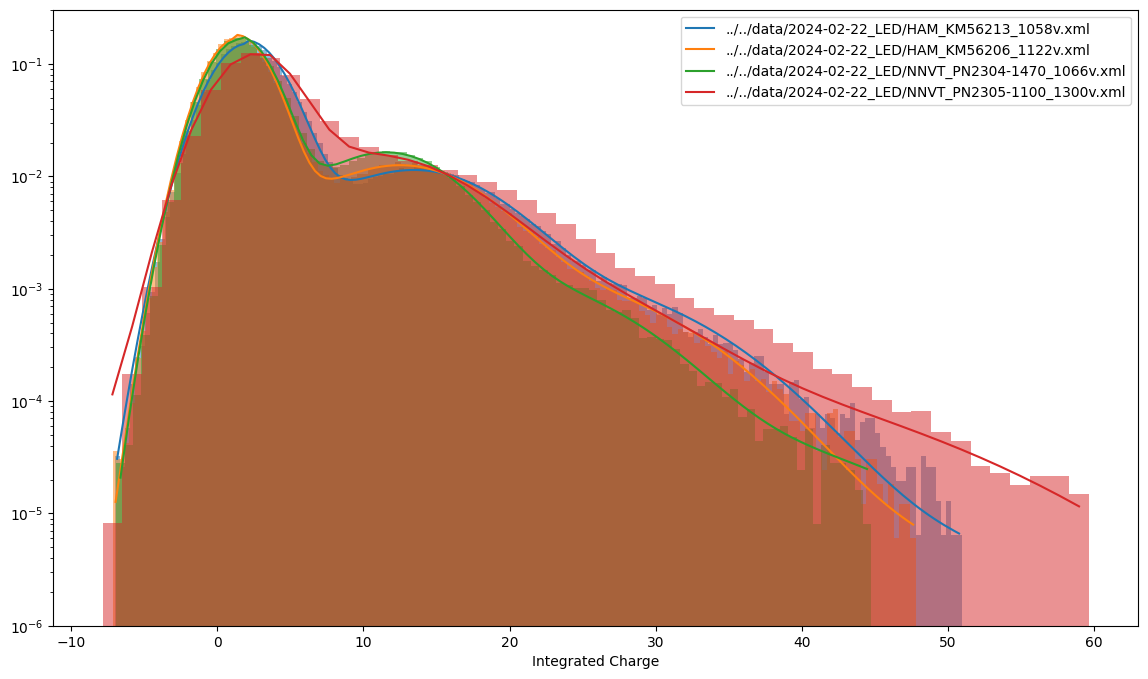

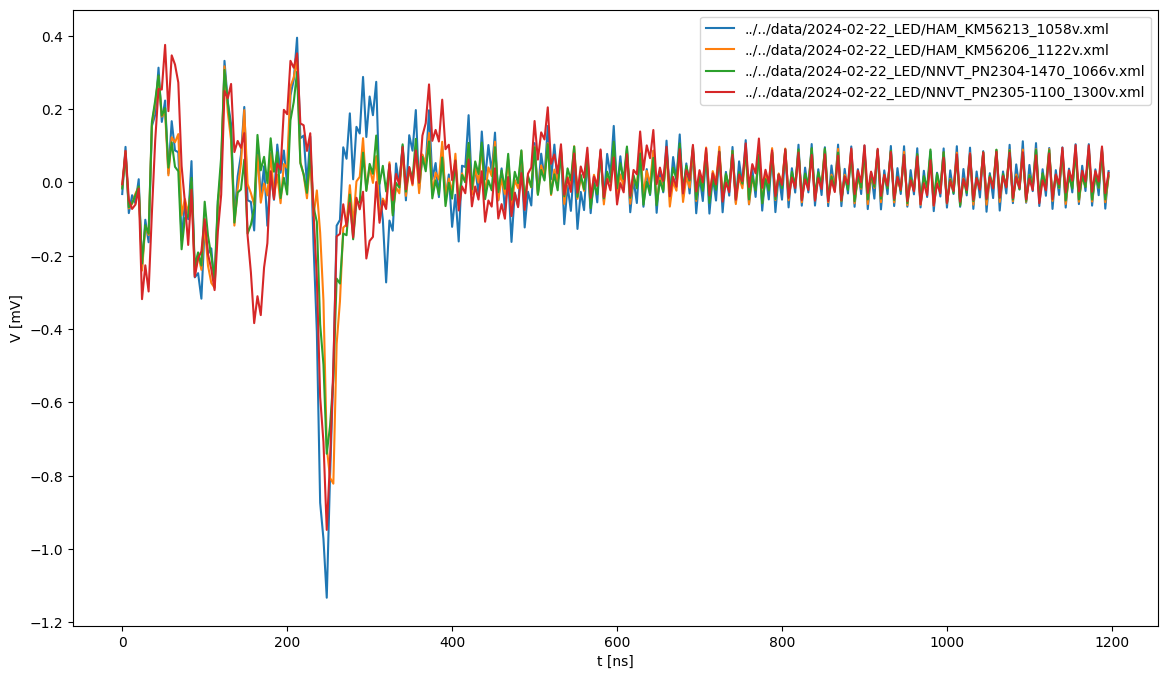

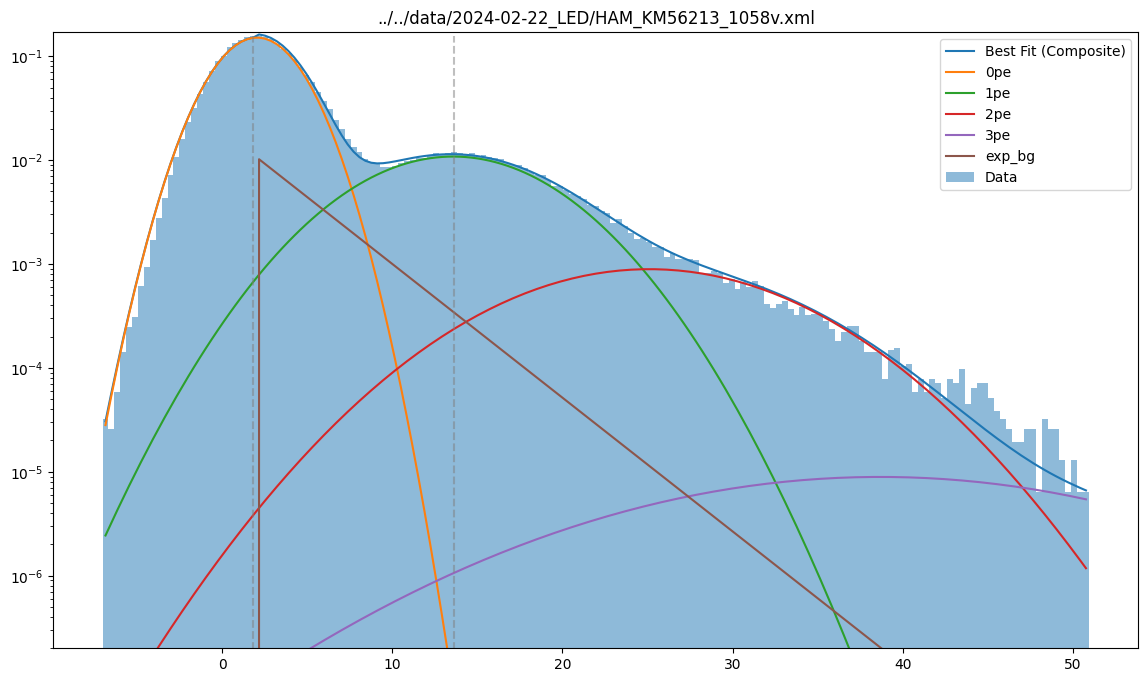

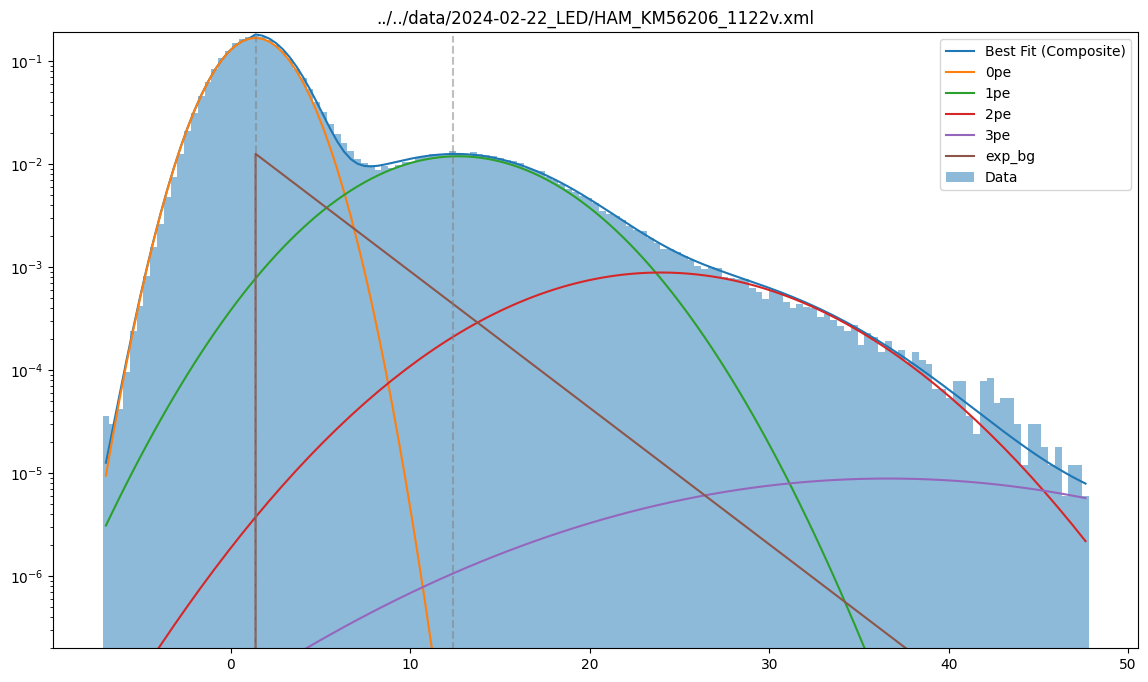

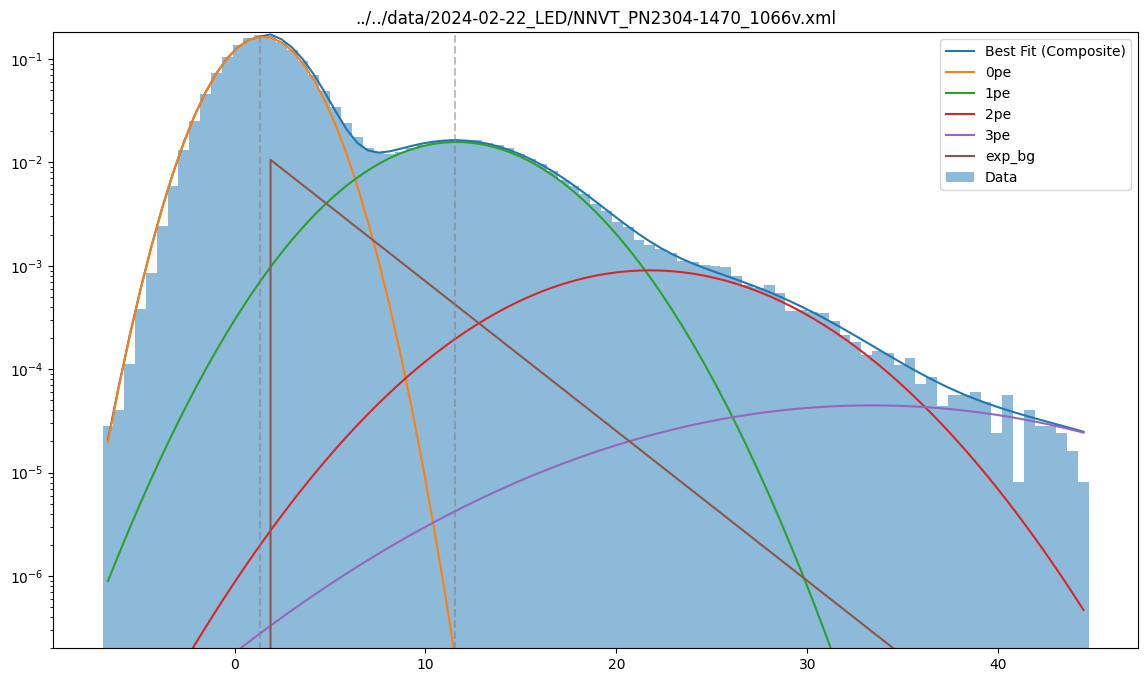

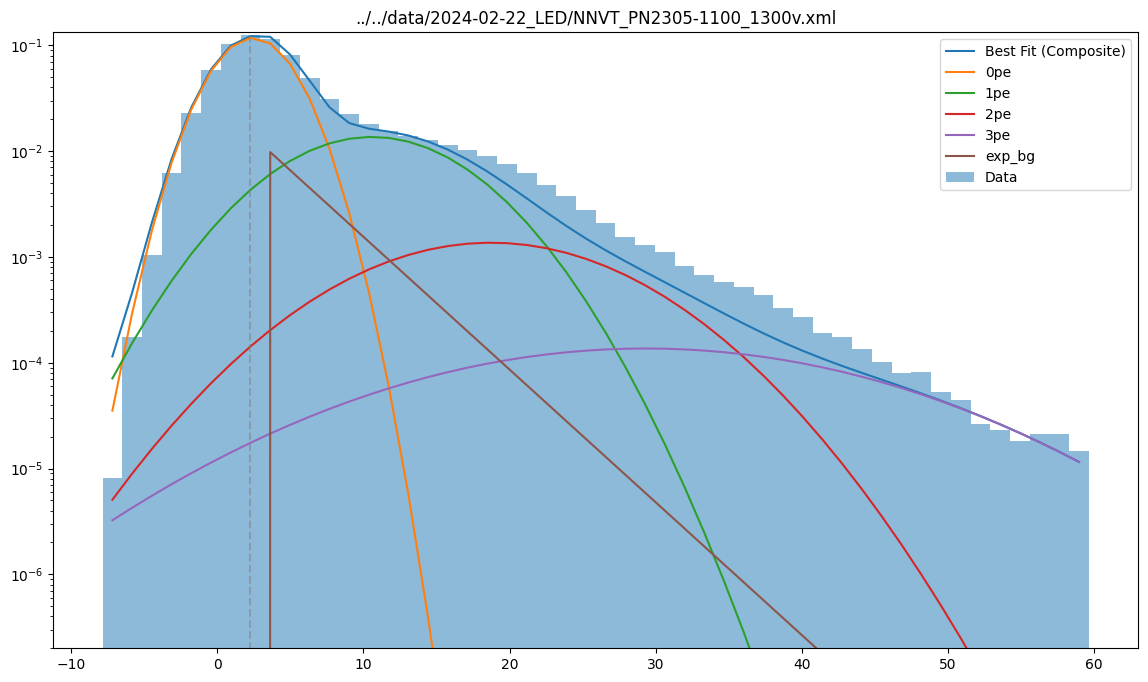

In [22]:
#ch_labels = ['PN2304-1470', 'PN2305-1100']
ch_labels = ['KM56206', 'KM56213', 'PN2304-1470', 'PN2305-1100']
ch_labels = ['PN2304-1470', 'H11901P-04']
ch_labels = ['KM56206', 'H11901P-04']
#fit_model = 'luminous'
fit_model = ''

options = ['--q', '--save', '--save_plots', '-f', files, '--fit_model', fit_model]  # LED measurement
#options = ['--dr', '--save', '--save_plots', '-f', files, '--channels', ch_labels] # Dark rate measurement

args = parser.parse_args(args=options)

fnames = args.file
if args.q:
    process_files_q(args)
elif args.dr:
    process_files_dr(args)
